In [16]:
import scanpy as sc 
import anndata
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os

import datetime


In [14]:
#Define constants here 
#set seed to 1 for reproducibility of results
np.random.seed(1)
#Current date format is YYYYMMDD with automatically updated date
today = datetime.datetime.now().strftime("%Y%m%d")

<h3> 1. Load .h5ad and mapping file </h3>

In [3]:
def read_10x_output(file_path, smp_list, metadata=None, type = 'raw', umi_filter=5):
    import os
    
    #Writing output from separate samples, processed using CellRanger, into a dictionary of Scanpy objects:
    ad = {}

    #Generate AnnData for each sample
    for sample_name in smp_list:
        path = file_path + sample_name
        for i in os.listdir(path):
            if type in i and 'h5' in i:
                file = i
        ad[sample_name] = sc.read_10x_h5(file_path + sample_name +'/'+file)
        ad[sample_name].var.rename(columns = {'gene_ids':'ENSEMBL'}, inplace = True)
        ad[sample_name].var['SYMBOL'] = ad[sample_name].var.index
        ad[sample_name].var.index = ad[sample_name].var['ENSEMBL']
        ad[sample_name].var.drop(columns=['ENSEMBL'], inplace=True)
        #ad[sample_name].var_names_make_unique() 
        
        
        sc.pp.calculate_qc_metrics(ad[sample_name], inplace=True)
        ad[sample_name] = ad[sample_name][ad[sample_name].obs['total_counts'] > umi_filter, :]
        ad[sample_name].var['mt'] = [gene.startswith('mt-') 
                                     for gene in ad[sample_name].var['SYMBOL']]
        ad[sample_name].obs['mt_frac'] = (ad[sample_name][:, 
               ad[sample_name].var['mt'].tolist()].X.sum(1).A.squeeze() 
                                          / ad[sample_name].obs['total_counts'])
        
        ad[sample_name].obs['sample'] = sample_name
        ad[sample_name].obs['barcode'] = ad[sample_name].obs_names
        ad[sample_name].obs_names = ad[sample_name].obs['sample']+"_"+ad[sample_name].obs['barcode']

    #Merge AnnData objects from all the samples together    
    from scipy.sparse import vstack
    stack = vstack([ad[x].X for x in smp_list]) # stack data
    adata = sc.AnnData(stack, var = ad[smp_list[0]].var)
    adata.obs = pd.concat([ad[x].obs for x in smp_list], axis = 0)

    if metadata is not None:
        #Add cleaned metadata to the Anndata.obs table
        obs_merged = pd.merge(left = adata.obs, right = metadata, 
                              how = "left", left_on="sample", right_on="sample")
        obs_merged.index = obs_merged['sample']+"_"+obs_merged['barcode']
        print(obs_merged.index.equals(adata.obs.index))
        adata.obs = obs_merged

    return adata, ad


In [4]:
#Create a sample list in form of a dataframe to be concatenated by the read_10x_output function
sample_list = pd.DataFrame({
    'sample': ['cellranger710_count_05e682d5679826b9b76d6bec731bbe61']
})

In [5]:
#Save results in the following folder (create if it doesn't exist)

results_folder = '/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2state_tf_activation/data/pilot_5_prime_dec_2022/'

#Read in 10x data in raw and filtered format
adata, ad_list = read_10x_output(
    sc_data_folder, 
    smp_list=sample_list['sample'],
    metadata=sample_list, type = 'raw')
# export aggregated and pre-processed data
# adata.write(f'{results_folder}{today}_all_cells_with_empty.h5ad')

adata, ad_list = read_10x_output(
    sc_data_folder, 
    smp_list=sample_list['sample'],
    metadata=sample_list, type = 'filtered')
# export aggregated and pre-processed data
# adata.write(f'{results_folder}{today}_all_cells.h5ad')

/home/jovyan/my-conda-envs/cell_2_state/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/tmp/ipykernel_2194/435707439.py:23: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[sample_name].var['mt'] = [gene.startswith('mt-')


True


/home/jovyan/my-conda-envs/cell_2_state/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_2194/435707439.py:23: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[sample_name].var['mt'] = [gene.startswith('mt-')


True


In [8]:
#Read in sgRNA sequences to count reads per guide
sgrna_df=pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/feature_reference.csv')
#Append additional sgRNA sequences that were not included in the data by appending rows to the dataframe
sgrna_rest_df = pd.DataFrame(
    [[
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "AGTCGCGATCGAACACTCGC",
        "CRISPR Guide Capture"
        ],
    [
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "CGGTCCGTAGGCACGTCTGC",
        "CRISPR Guide Capture"]],
    columns= sgrna_df.columns
)
#rowwise concatenation of the two dataframes
sgrna_df = pd.concat([sgrna_df, sgrna_rest_df], axis=0,ignore_index=True)

In [57]:
sgrna_df

,id,name,read,pattern,sequence,feature_type
0,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),TGTGATGGAGGCGCTGCTGC,CRISPR Guide Capture
1,AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCT...,AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCT...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CAGGGACACTTCCCTGTGAC,CRISPR Guide Capture
2,ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTT...,ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTT...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CGCTGCTGCAGCGAGCGGCC,CRISPR Guide Capture
3,ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCT...,ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCT...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CTCGCTGCAGCAGCGGGGAC,CRISPR Guide Capture
4,DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATA...,DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATA...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CTCTATGCAGATCTGGACGC,CRISPR Guide Capture
...,...,...,...,...,...,...
81,TSHZ3_AGTTTGACAAATCGCTCCAG_TSHZ3_TTCCCATTCCGCC...,TSHZ3_AGTTTGACAAATCGCTCCAG_TSHZ3_TTCCCATTCCGCC...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CGCTGCCGGCGGAATGGGAC,CRISPR Guide Capture
82,TSHZ3_CAAATCGCTCCAGAGGCCAG_TSHZ3_GAGGAGGACCGCG...,TSHZ3_CAAATCGCTCCAGAGGCCAG_TSHZ3_GAGGAGGACCGCG...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CCGGCAGCGCGGTCCTCCTC,CRISPR Guide Capture
83,ONE_INTERGENIC_SITE_1194_GATTGTCATCTCCATAGCTG_...,ONE_INTERGENIC_SITE_1194_GATTGTCATCTCCATAGCTG_...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),CGCTGCACGATAAGGTCTTC,CRISPR Guide Capture
84,sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGA...,sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGA...,R2,TGCTGTTTCCAGCATAGCTCTTAAAC(BC),AGTCGCGATCGAACACTCGC,CRISPR Guide Capture


In [56]:
#Read in protospace call per cell file to dataframe
protospacer_df = pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/crispr_analysis/protospacer_calls_per_cell.csv')


In [57]:
protospacer_df.sort_values(by=['num_features','num_umis'], inplace=True)

In [27]:
protospacer_df.tail(60)




,cell_barcode,num_features,feature_call,num_umis
713,TACTTGTCATTCGACA-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,73|16|13|58|46|4|15|37|17|24|16|30|18|32|176|7...
703,GATGAGGGTCTCGTTC-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,78|22|28|63|52|14|33|21|16|30|23|16|31|180|89|...
780,TACACGAAGCGTGTCC-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,83|22|19|51|57|4|24|13|29|18|33|26|18|39|222|8...
763,GTGCGGTAGCTGATAA-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,85|8|32|13|103|747|59|1178|162|1028|306|14|45|...
978,TACGGATCAATGAATG-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,96|6|7|20|14|2396|123|377|46|30|298|24|33|1133...
963,CGTAGGCTCGCCTGTT-1,18,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,96|8|23|69|211|7|130|66|258|11|11|22|92|32|121...
991,ACTGTCCGTCTAGTGT-1,19,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,1637|286|7|21|52|73|375|22|76|523|52|570|18|24...
2884,GAATGAATCTCAAGTG-1,19,DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACA...,17|13|42|30|48|38|241|93|298|1731|80|36|92|98|...
812,CCACGGAGTCAGCTAT-1,19,AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAG...,194|29|17|42|16|18|10|75|257|17|357|86|84|64|5...
1781,TTAGGCACACGTGAGA-1,19,ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTT...,326|61|826|147|29|52|41|104|14|32|77|22|283|15...


In [59]:
#Create list from feature call and numeric umis assignment which should be split by "|"
protospacer_df['feature_call_split']=protospacer_df['feature_call'].str.split('|')
protospacer_df['num_umis_split']=protospacer_df['num_umis'].str.split('|')

In [72]:
#map guide counts/cell to barcodes
protospacer_counts=[dict(zip(a,b)) for a,b in zip(protospacer_df.feature_call_split,protospacer_df.num_umis_split)]

In [73]:
protospacer_counts_df=pd.DataFrame(protospacer_counts)

In [82]:
protospacer_df[['cell_barcode','num_features']].concatenate(protospacer_counts_df)

AttributeError: 'DataFrame' object has no attribute 'concatenate'

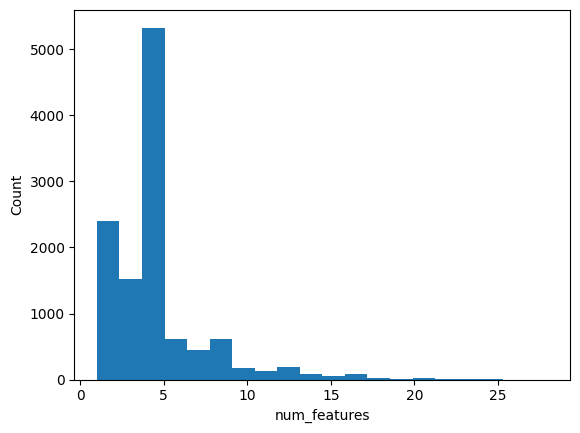

In [54]:
#histogram of numeric features
plt.hist(protospacer_df.num_features,bins=20);
plt.xlabel('num_features');
plt.ylabel('Count')
plt.show()

In [60]:
len(protospacer_df.feature_call.unique())

1530

In [40]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac,sample,barcode
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_AAACCTGAGAATCTCC-1,6028,8.704336,19097.0,9.857339,17.971409,25.878410,34.827460,47.677646,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,AAACCTGAGAATCTCC-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_AAACCTGAGAGTACCG-1,8290,9.022926,47036.0,10.758690,20.665023,29.698529,38.774556,51.724211,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,AAACCTGAGAGTACCG-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_AAACCTGAGCTAGTTC-1,5973,8.695172,29295.0,10.285206,23.604711,33.947773,43.894863,58.088411,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,AAACCTGAGCTAGTTC-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_AAACCTGAGTGGTAGC-1,7235,8.886824,33495.0,10.419181,19.358113,27.902672,36.886102,49.720854,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,AAACCTGAGTGGTAGC-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_AAACCTGCACGGATAG-1,6792,8.823648,30050.0,10.310651,20.569052,29.906822,39.021631,52.259567,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,AAACCTGCACGGATAG-1
...,...,...,...,...,...,...,...,...,...,...,...
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_TTTGTCAGTTTGTTGG-1,6645,8.801770,22523.0,10.022337,17.559828,25.476180,33.836523,46.401456,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,TTTGTCAGTTTGTTGG-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_TTTGTCATCACCTCGT-1,5836,8.671972,18445.0,9.822603,18.400651,26.928707,35.543508,48.479263,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,TTTGTCATCACCTCGT-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_TTTGTCATCTACCAGA-1,4994,8.516193,16715.0,9.724122,21.543524,31.379001,40.873467,54.316482,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,TTTGTCATCTACCAGA-1
cellranger710_count_05e682d5679826b9b76d6bec731bbe61_TTTGTCATCTATGTGG-1,5933,8.688454,17312.0,9.759212,17.074861,24.740065,32.798059,45.563771,0.0,cellranger710_count_05e682d5679826b9b76d6bec73...,TTTGTCATCTATGTGG-1


<h3> 2. Data exploration by visualisation</h3>

In [12]:
def subset_cells(
    adata,
    cells_per_category=10000,
    stratify_category_key='sample',
):
    
    adata.obs['_cell_index'] = np.arange(adata.n_obs)
    subset_ind = list()
    
    for ct in adata.obs[stratify_category_key].unique():
        ind = adata.obs[stratify_category_key] == ct
        subset_ind_ = adata.obs['_cell_index'][ind]
        n_samples = np.min((len(subset_ind_), cells_per_category))
        subset_ind = subset_ind + list(np.random.choice(subset_ind_, size=n_samples, replace=False))
    print(len(subset_ind))
    
    return adata[subset_ind, :].copy()

def compute_pcs_knn_umap(
    adata_subset, stratify_category_key='sample', 
    tech_category_key=None, plot_category_keys=list(), 
    scale_max_value=10, n_comps=100, n_neighbors=15,
):
    adata_subset.obs['total_counts'] = np.array(adata_subset.X.sum(1)).flatten()
    adata_subset.layers['counts'] = adata_subset.X.copy()
    # No normalisation by total count
    sc.pp.log1p(adata_subset)
    # Scale with no HVG selection
    if tech_category_key is None:
        sc.pp.scale(adata_subset, max_value=scale_max_value)
    else:
        for tech in adata_subset.obs[tech_category_key].unique():
            mu, std = compute_mu_std(adata_subset[adata_subset.obs[tech_category_key] == tech].X)
            adata_subset[adata_subset.obs[tech_category_key] == tech].X = (
                np.minimum((adata_subset[adata_subset.obs[tech_category_key] == tech].X - mu) / std, scale_max_value)
            )
    # A lot of PC dimensions
    sc.tl.pca(adata_subset, svd_solver='arpack', n_comps=n_comps, use_highly_variable=False)
    # Plot PCs to confirm that PC1 is indeed linked to total count
    # sc.pl.pca(adata_subset, color=['total_counts'],
    #           components=['1,2', '2,3', '4,5'],
    #           color_map = 'RdPu', ncols = 3, legend_loc='on data',
    #           legend_fontsize=10)
    plt.hist2d(adata_subset.obsm['X_pca'][:, 0].flatten(),
               adata_subset.obs['total_counts'].values.flatten(),
               bins=200,
               norm=mpl.colors.LogNorm());
    plt.xlabel('PC 1');
    plt.ylabel('Total RNA count');
    plt.show()

    # Remove PC1
    adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca'][:, 1:]
    adata_subset.varm['PCs'] = adata_subset.varm['PCs'][:, 1:]

    # compute KNN and UMAP to see how well this represents the dataset
    sc.pp.neighbors(adata_subset, n_neighbors=n_neighbors)
    sc.tl.umap(adata_subset, min_dist = 0.4, spread = 1.5)

    # Plot UMAP
    sc.pl.umap(adata_subset, color=[stratify_category_key] + plot_category_keys,
               color_map = 'RdPu', ncols = 3, #legend_loc='on data',
               legend_fontsize=10)
    return adata_subset

def compute_mu_std(X):
        
    mu = np.array(X.mean(0))
    mu_sq = mu ** 2
    X = X.copy()
    X.data = X.data ** 2
    sq_mu = np.array(X.mean(0))
    std = np.sqrt(sq_mu - mu_sq) + 1e-8
    
    return mu, std

In [15]:
cells_per_category=20000
stratify_category_key='sample'
tech_category_key=None


adata_subset = subset_cells(
    adata, cells_per_category=cells_per_category, 
    stratify_category_key=stratify_category_key,
)

12797


Global seed set to 0
/home/jovyan/my-conda-envs/cell_2_state/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/cell_2_state/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/home/jovyan/my-conda-envs/cell_2_state/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


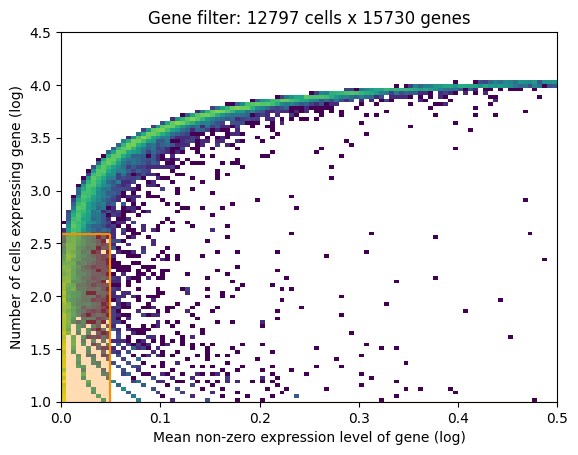

In [17]:
# select informative genes but keep all barcodes
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_subset, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
plt.show()

#find target transcription factors to keep 
#use reference list with all transcription factors
targeted_tfs=sgrna_df['id'].str.split('_').str[0].values
#check if TFs are in the gene names
targeted_tfs_ensembl = list(adata_subset.var_names[adata_subset.var['SYMBOL'].isin(targeted_tfs)])

#find transcription factors 
targeted_tfs=sgrna_df['id'].str.split('_').str[0].values
targeted_tfs_ensembl = list(adata_subset.var_names[adata_subset.var['SYMBOL'].isin(targeted_tfs)])

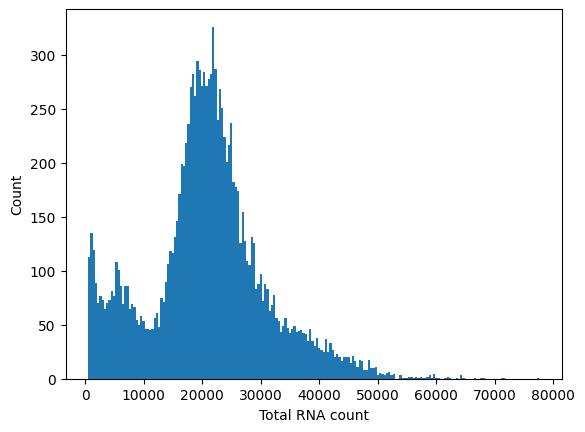

In [61]:
plt.hist(adata_subset.obs['total_counts'].values.flatten(), bins=200);
plt.xlabel('Total RNA count');
plt.ylabel('Count')
plt.show()

In [31]:
adata_subset.var['SYMBOL'].head(60)

ENSEMBL
ENSG00000243485    MIR1302-2HG
ENSG00000237613        FAM138A
ENSG00000186092          OR4F5
ENSG00000238009     AL627309.1
ENSG00000239945     AL627309.3
ENSG00000239906     AL627309.2
ENSG00000241860     AL627309.5
ENSG00000241599     AL627309.4
ENSG00000286448     AP006222.2
ENSG00000236601     AL732372.1
ENSG00000284733         OR4F29
ENSG00000235146     AC114498.1
ENSG00000284662         OR4F16
ENSG00000229905     AL669831.2
ENSG00000237491      LINC01409
ENSG00000177757         FAM87B
ENSG00000228794      LINC01128
ENSG00000225880      LINC00115
ENSG00000230368         FAM41C
ENSG00000272438     AL645608.6
ENSG00000230699     AL645608.2
ENSG00000241180     AL645608.4
ENSG00000223764      LINC02593
ENSG00000187634         SAMD11
ENSG00000188976          NOC2L
ENSG00000187961         KLHL17
ENSG00000187583        PLEKHN1
ENSG00000187642          PERM1
ENSG00000272512     AL645608.7
ENSG00000188290           HES4
ENSG00000187608          ISG15
ENSG00000224969     AL645608.1


In [ ]:
#look at differentially expressed genes 